In [16]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import random
import nibabel as nib
from torch.utils.tensorboard import SummaryWriter
import glob as glob
import ipywidgets as widgets
from IPython.display import display


In [17]:
class VolumeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.volume_files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(('.nii', '.nii.gz'))] 

    def __len__(self):
        return len(self.volume_files)

    def __getitem__(self, idx):
        volume_path = self.volume_files[idx]
        volume = nib.load(volume_path).get_fdata()  
        volume = torch.from_numpy(volume).float().unsqueeze(0)
        volume = (volume - volume.min()) / (volume.max() - volume.min())
        high_res_volume = F.interpolate(volume.unsqueeze(0), size=(128, 128, 128), mode='trilinear', align_corners=False).squeeze(0)
        low_res_volume = F.interpolate(high_res_volume.unsqueeze(0), size=(80, 80, 80), mode='trilinear', align_corners=False).squeeze(0)

        if self.transform:
            low_res_volume = self.transform(low_res_volume)

        return low_res_volume, high_res_volume


In [18]:
def random_crop(volume, crop_size):
    w, h, d = volume.shape[1:]
    th, tw, td = crop_size
    
    if w == th and h == tw and d == td:
        return volume

    x1 = torch.randint(0, w - th + 1, (1,))
    y1 = torch.randint(0, h - tw + 1, (1,))
    z1 = torch.randint(0, d - td + 1, (1,))

    cropped_volume = volume[:, x1:x1+th, y1:y1+tw, z1:z1+td]

    # Pad if necessary to maintain original size
    pad_left = max(0, -x1)
    pad_right = max(0, x1 + th - w)
    pad_top = max(0, -y1)
    pad_bottom = max(0, y1 + tw - h)
    pad_front = max(0, -z1)
    pad_back = max(0, z1 + td - d)

    cropped_volume = torch.nn.functional.pad(cropped_volume, (pad_left, pad_right, pad_top, pad_bottom, pad_front, pad_back))

    return cropped_volume

In [19]:
root_dir = "imagesTr"


dataset = VolumeDataset(root_dir=root_dir)
#dataset = VolumeDataset(root_dir=root_dir)

In [20]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

Train size: 160, Validation size: 20, Test size: 21


In [21]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [22]:
num_train_images = len(train_dataset)
num_val_images = len(val_dataset)
num_test_images = len(test_dataset)

print(f"Number of images in Training set: {num_train_images}")
print(f"Number of images in Validation set: {num_val_images}")
print(f"Number of images in Test set: {num_test_images}")

Number of images in Training set: 160
Number of images in Validation set: 20
Number of images in Test set: 21


In [23]:
num_train_batches = len(train_loader)
num_val_batches = len(val_loader)
num_test_batches = len(test_loader)

print(f"Number of batches in Training set: {num_train_batches}") 
print(f"Number of batches in Validation set: {num_val_batches}")
print(f"Number of batches in Test set: {num_test_batches}")

Number of batches in Training set: 40
Number of batches in Validation set: 5
Number of batches in Test set: 6


In [24]:
class FSRCNN_3D(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = nn.Conv3d(in_channels=1, out_channels=56, kernel_size=5, padding=2)
        self.conv_2 = nn.Conv3d(in_channels=56, out_channels=12, kernel_size=1, padding=0)
        self.conv_3 = nn.Conv3d(in_channels=12, out_channels=12, kernel_size=3, padding=1)
        self.conv_4 = nn.Conv3d(in_channels=12, out_channels=12, kernel_size=3, padding=1)
        self.conv_5 = nn.Conv3d(in_channels=12, out_channels=12, kernel_size=3, padding=1)
        self.conv_6 = nn.Conv3d(in_channels=12, out_channels=12, kernel_size=3, padding=1)
        self.conv_7 = nn.Conv3d(in_channels=12, out_channels=56, kernel_size=1, padding=0)
        self.de_conv_1 = nn.ConvTranspose3d(in_channels=56, out_channels=1, kernel_size=9, stride=3, padding=3, output_padding=0)
        self.dropout = nn.Dropout(p=0.5)


    def forward(self, x):
        output = self.conv_1(x)
        output = F.relu(output)
        output = self.conv_2(output)
        output = F.relu(output)
        output = self.conv_3(output)
        output = F.relu(output)
        output = self.conv_4(output)
        output = F.relu(output)
        output = self.conv_5(output)
        output = F.relu(output)
        output = self.conv_6(output)
        output = F.relu(output)
        output = self.conv_7(output)
        output = self.dropout(output)
        output = self.de_conv_1(output)
        output = F.relu(output)
        return output

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = FSRCNN_3D()
model= nn.DataParallel(model)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

cuda


In [26]:
def calculate_metrics(output, target):
    output_np = output.squeeze().cpu().numpy()  
    target_np = target.squeeze().cpu().numpy()
    ssim_val = np.mean([ssim(o, t, data_range=t.max() - t.min(), channel_axis=-1, win_size=5)
                        for o, t in zip(output_np, target_np)])
    psnr_val = np.mean([psnr(t, o, data_range=t.max() - t.min()) for o, t in zip(output_np, target_np)])
    mse_val = np.mean((output_np - target_np) ** 2)
    
    return ssim_val, psnr_val, mse_val

In [27]:
def visualize_images(original, downsampled, output):
    plt.figure(figsize=(12, 4))

    depth = original.shape[1]
    mid_slice = min(depth // 2, original.shape[1] - 1) 
    
    plt.subplot(1, 3, 1)
    plt.imshow(original[:, mid_slice, :, :].cpu().permute(1, 2, 0).numpy(), cmap="gray")
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    depth_upsampled = downsampled.shape[1]
    mid_slice_downsmapled = min(depth_upsampled // 2, depth_upsampled - 1)  # Adjusted for upsampled depth
    plt.imshow(downsampled[:, mid_slice_downsmapled, :, :].cpu().permute(1, 2, 0).numpy(), cmap="gray")
    plt.title('Low Resolution Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    depth_output = output.shape[1]
    mid_slice_output = min(depth_output // 2, depth_output - 1)  # Adjusted for output depth
    plt.imshow(output[:, mid_slice_output, :, :].cpu().permute(1, 2, 0).numpy(), cmap="gray")
    plt.title('Model Output')
    plt.axis('off')
    
    plt.show()
    



In [28]:
from tqdm import tqdm
import time

Validation - Epoch [1/200], SSIM: 0.1861, PSNR: 11.6120, MSE: 0.0291


Validation - Epoch [2/200], SSIM: 0.2360, PSNR: 17.0738, MSE: 0.0103


Validation - Epoch [3/200], SSIM: 0.4633, PSNR: 19.0460, MSE: 0.0066


Validation - Epoch [4/200], SSIM: 0.5638, PSNR: 21.0758, MSE: 0.0047


Validation - Epoch [5/200], SSIM: 0.6128, PSNR: 21.7445, MSE: 0.0057


Validation - Epoch [6/200], SSIM: 0.6278, PSNR: 21.8518, MSE: 0.0042


Validation - Epoch [7/200], SSIM: 0.6667, PSNR: 22.8964, MSE: 0.0015


Validation - Epoch [8/200], SSIM: 0.6805, PSNR: 22.8864, MSE: 0.0035


Validation - Epoch [9/200], SSIM: 0.6037, PSNR: 23.2092, MSE: 0.0013


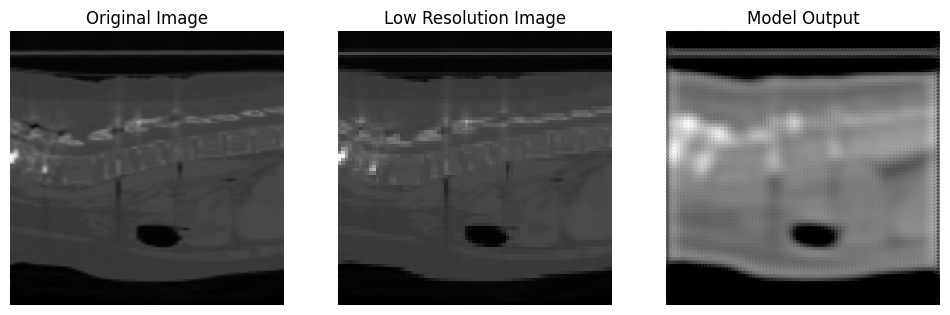

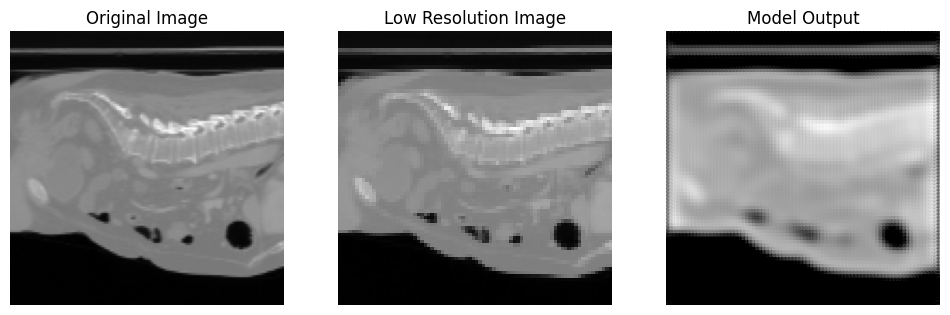

Validation - Epoch [10/200], SSIM: 0.6094, PSNR: 23.4355, MSE: 0.0019


Validation - Epoch [11/200], SSIM: 0.6090, PSNR: 23.3937, MSE: 0.0020


Validation - Epoch [12/200], SSIM: 0.5000, PSNR: 22.5750, MSE: 0.0017


Validation - Epoch [13/200], SSIM: 0.5414, PSNR: 22.9891, MSE: 0.0021


Validation - Epoch [14/200], SSIM: 0.5603, PSNR: 23.7429, MSE: 0.0019


Validation - Epoch [15/200], SSIM: 0.6005, PSNR: 23.1372, MSE: 0.0012


Validation - Epoch [16/200], SSIM: 0.6092, PSNR: 24.3073, MSE: 0.0024


Validation - Epoch [17/200], SSIM: 0.6724, PSNR: 24.7095, MSE: 0.0017


Validation - Epoch [18/200], SSIM: 0.6536, PSNR: 23.1909, MSE: 0.0010


Validation - Epoch [19/200], SSIM: 0.5930, PSNR: 23.3969, MSE: 0.0021


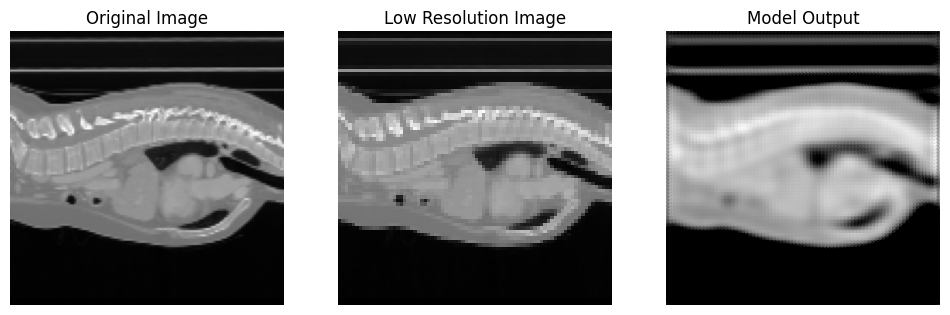

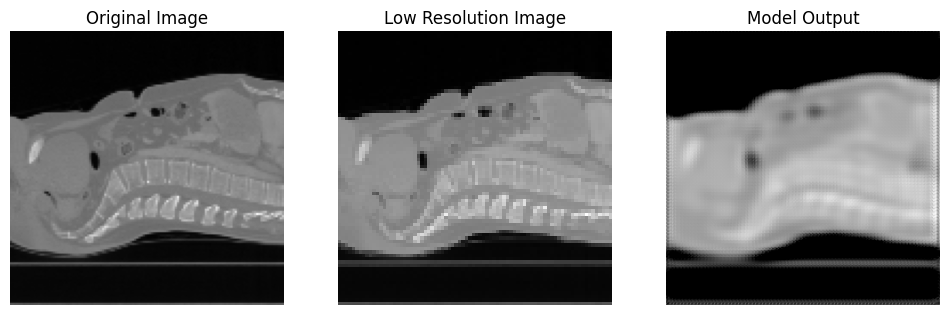

Validation - Epoch [20/200], SSIM: 0.5617, PSNR: 23.8109, MSE: 0.0030


Validation - Epoch [21/200], SSIM: 0.5533, PSNR: 24.1822, MSE: 0.0015


Validation - Epoch [22/200], SSIM: 0.7255, PSNR: 25.8444, MSE: 0.0013


Validation - Epoch [23/200], SSIM: 0.6879, PSNR: 24.7250, MSE: 0.0007


Validation - Epoch [24/200], SSIM: 0.6141, PSNR: 24.5014, MSE: 0.0010


Validation - Epoch [25/200], SSIM: 0.6573, PSNR: 24.4135, MSE: 0.0022


Validation - Epoch [26/200], SSIM: 0.6368, PSNR: 25.0576, MSE: 0.0005


Validation - Epoch [27/200], SSIM: 0.6431, PSNR: 25.3165, MSE: 0.0005


Validation - Epoch [28/200], SSIM: 0.7281, PSNR: 26.7288, MSE: 0.0007


Validation - Epoch [29/200], SSIM: 0.6229, PSNR: 25.7640, MSE: 0.0012


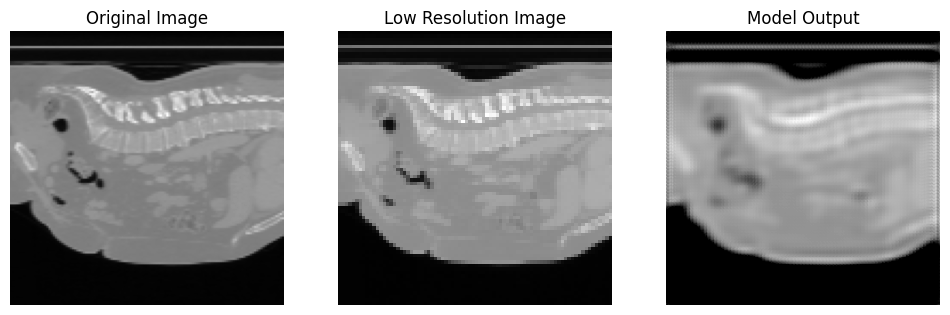

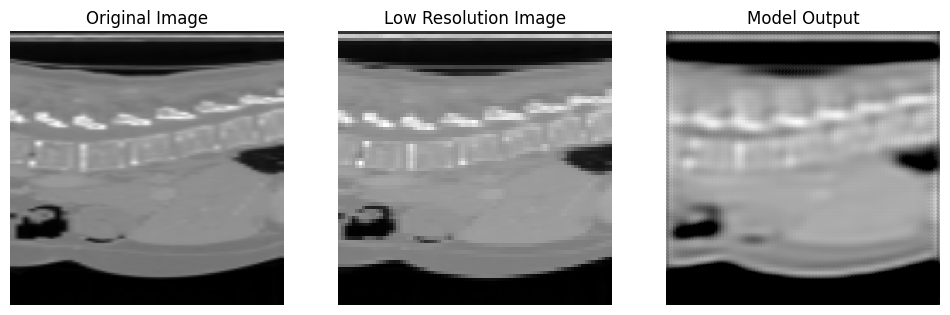

Validation - Epoch [30/200], SSIM: 0.7182, PSNR: 26.3336, MSE: 0.0014


Validation - Epoch [31/200], SSIM: 0.6852, PSNR: 25.9748, MSE: 0.0015


Validation - Epoch [32/200], SSIM: 0.7140, PSNR: 26.0016, MSE: 0.0021


Validation - Epoch [33/200], SSIM: 0.6374, PSNR: 25.7671, MSE: 0.0008


Validation - Epoch [34/200], SSIM: 0.6084, PSNR: 25.5394, MSE: 0.0020


Validation - Epoch [35/200], SSIM: 0.7322, PSNR: 26.8219, MSE: 0.0009


Validation - Epoch [36/200], SSIM: 0.7078, PSNR: 26.1911, MSE: 0.0017


Validation - Epoch [37/200], SSIM: 0.6752, PSNR: 26.8652, MSE: 0.0008


Validation - Epoch [38/200], SSIM: 0.5664, PSNR: 24.8686, MSE: 0.0014


Validation - Epoch [39/200], SSIM: 0.7199, PSNR: 26.3286, MSE: 0.0009


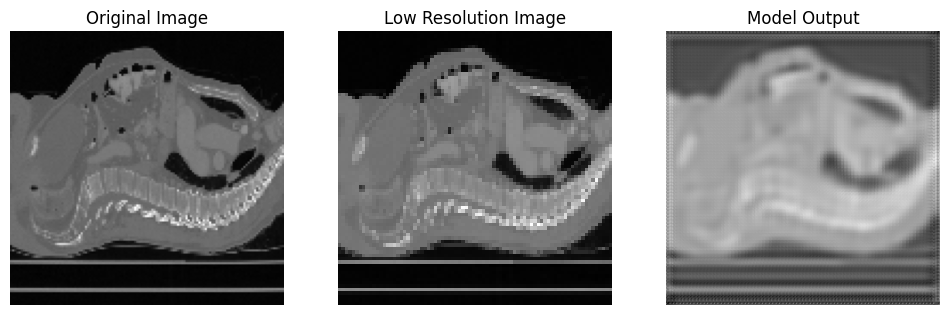

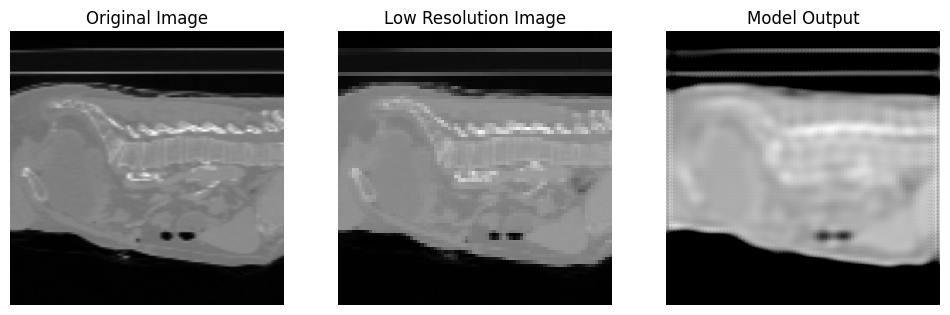

Validation - Epoch [40/200], SSIM: 0.6562, PSNR: 25.3600, MSE: 0.0008


Validation - Epoch [41/200], SSIM: 0.6359, PSNR: 26.4822, MSE: 0.0009


Validation - Epoch [42/200], SSIM: 0.7728, PSNR: 26.6160, MSE: 0.0010


Validation - Epoch [43/200], SSIM: 0.7406, PSNR: 26.9698, MSE: 0.0012


Validation - Epoch [44/200], SSIM: 0.6927, PSNR: 26.6535, MSE: 0.0014


Validation - Epoch [45/200], SSIM: 0.6741, PSNR: 25.9179, MSE: 0.0010


Validation - Epoch [46/200], SSIM: 0.6945, PSNR: 26.5607, MSE: 0.0010


Validation - Epoch [47/200], SSIM: 0.5811, PSNR: 25.3560, MSE: 0.0018


Validation - Epoch [48/200], SSIM: 0.6868, PSNR: 26.2379, MSE: 0.0015


Validation - Epoch [49/200], SSIM: 0.6215, PSNR: 26.1532, MSE: 0.0014


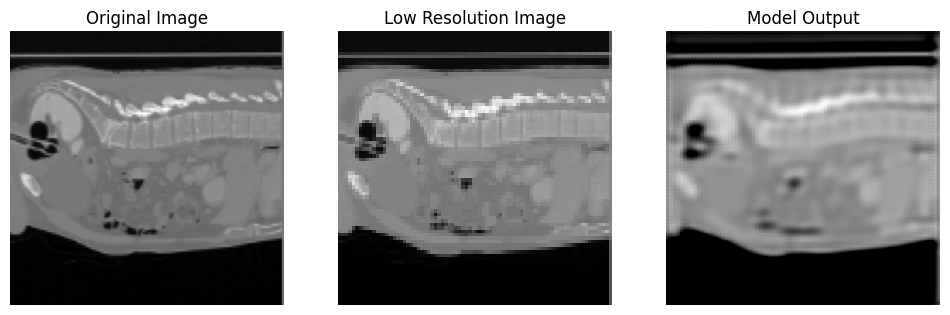

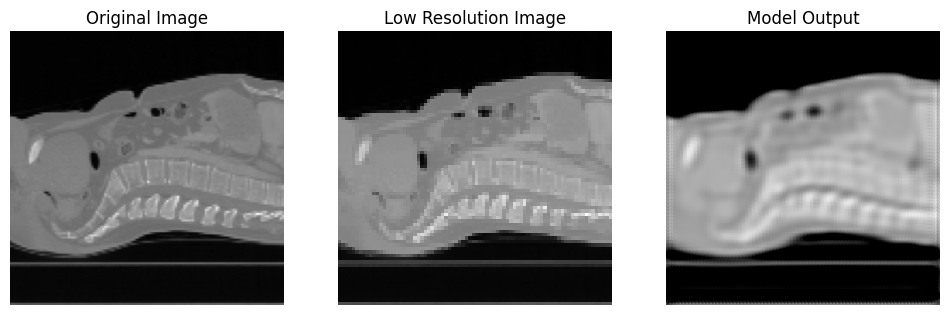

Validation - Epoch [50/200], SSIM: 0.6414, PSNR: 26.5885, MSE: 0.0014


Validation - Epoch [51/200], SSIM: 0.7331, PSNR: 27.2998, MSE: 0.0010


Validation - Epoch [52/200], SSIM: 0.7045, PSNR: 26.7744, MSE: 0.0010


Validation - Epoch [53/200], SSIM: 0.7356, PSNR: 27.4219, MSE: 0.0010


Validation - Epoch [54/200], SSIM: 0.6334, PSNR: 26.0667, MSE: 0.0012


Validation - Epoch [55/200], SSIM: 0.7759, PSNR: 28.1404, MSE: 0.0011


Validation - Epoch [56/200], SSIM: 0.7750, PSNR: 28.2631, MSE: 0.0008


Validation - Epoch [57/200], SSIM: 0.7332, PSNR: 27.5467, MSE: 0.0012


Validation - Epoch [58/200], SSIM: 0.7296, PSNR: 27.5565, MSE: 0.0003


Validation - Epoch [59/200], SSIM: 0.7117, PSNR: 27.3144, MSE: 0.0012


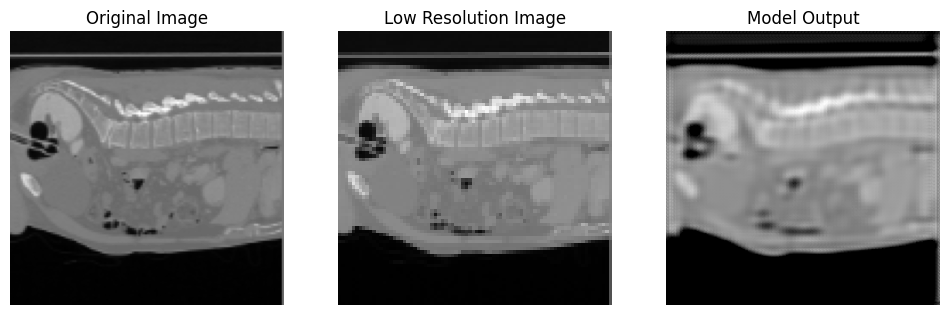

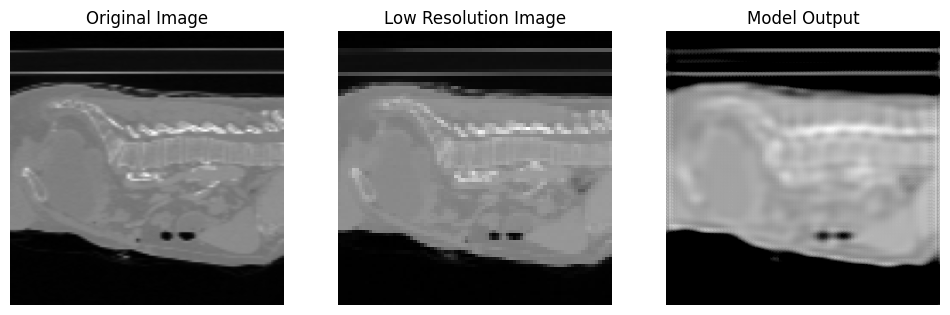

Validation - Epoch [60/200], SSIM: 0.6613, PSNR: 27.3586, MSE: 0.0008


Validation - Epoch [61/200], SSIM: 0.7029, PSNR: 27.3519, MSE: 0.0009


Validation - Epoch [62/200], SSIM: 0.5820, PSNR: 25.7378, MSE: 0.0014


Validation - Epoch [63/200], SSIM: 0.6420, PSNR: 27.2284, MSE: 0.0010


Validation - Epoch [64/200], SSIM: 0.7806, PSNR: 28.9342, MSE: 0.0010


Validation - Epoch [65/200], SSIM: 0.7051, PSNR: 26.5952, MSE: 0.0010


Validation - Epoch [66/200], SSIM: 0.7851, PSNR: 28.6932, MSE: 0.0007


Validation - Epoch [67/200], SSIM: 0.7906, PSNR: 29.0323, MSE: 0.0007


Validation - Epoch [68/200], SSIM: 0.6934, PSNR: 27.5857, MSE: 0.0006


Validation - Epoch [69/200], SSIM: 0.7480, PSNR: 27.0139, MSE: 0.0012


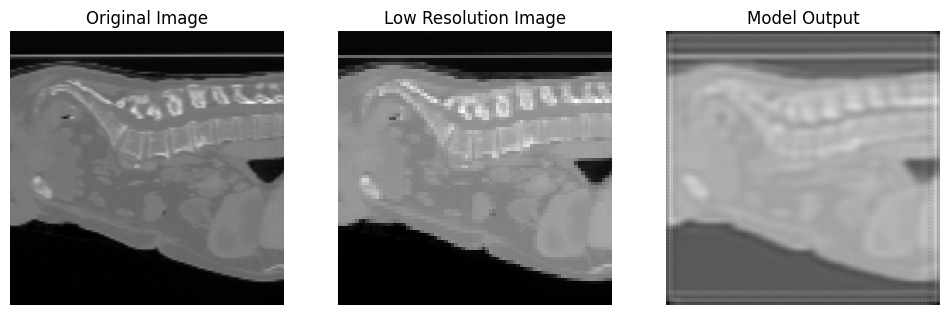

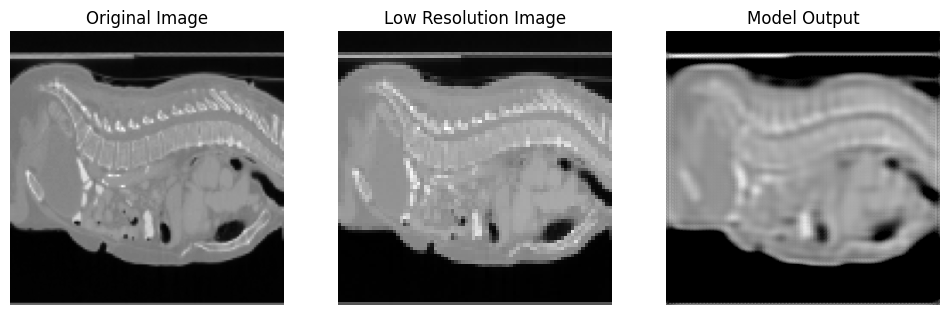

Validation - Epoch [70/200], SSIM: 0.7229, PSNR: 27.5854, MSE: 0.0008


Validation - Epoch [71/200], SSIM: 0.7905, PSNR: 28.8202, MSE: 0.0009


Validation - Epoch [72/200], SSIM: 0.7182, PSNR: 26.8889, MSE: 0.0010


Validation - Epoch [73/200], SSIM: 0.7593, PSNR: 28.2309, MSE: 0.0009


Validation - Epoch [74/200], SSIM: 0.8147, PSNR: 27.8301, MSE: 0.0007


Validation - Epoch [75/200], SSIM: 0.6160, PSNR: 26.6077, MSE: 0.0010


Validation - Epoch [76/200], SSIM: 0.6738, PSNR: 27.3254, MSE: 0.0010


Validation - Epoch [77/200], SSIM: 0.6387, PSNR: 27.3885, MSE: 0.0007


Validation - Epoch [78/200], SSIM: 0.7723, PSNR: 28.6038, MSE: 0.0006


Validation - Epoch [79/200], SSIM: 0.6550, PSNR: 27.1819, MSE: 0.0012


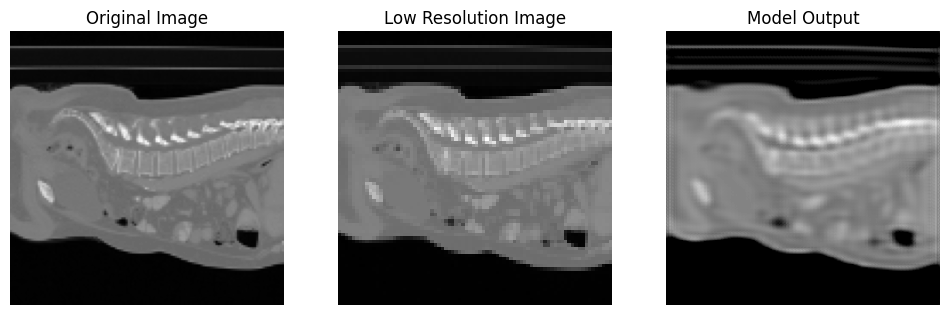

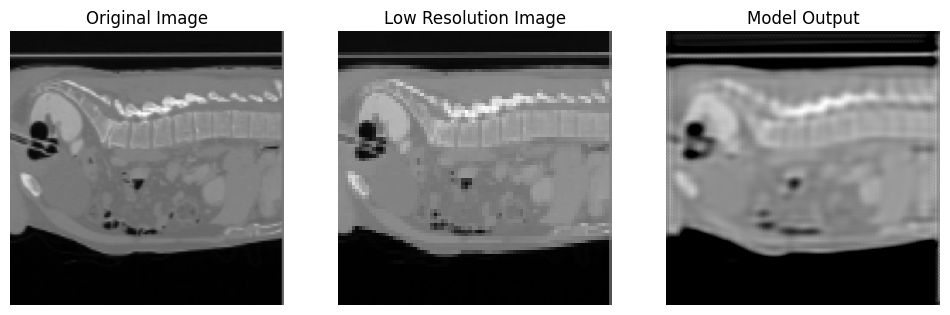

Validation - Epoch [80/200], SSIM: 0.6868, PSNR: 28.4792, MSE: 0.0008


Validation - Epoch [81/200], SSIM: 0.6235, PSNR: 26.7926, MSE: 0.0010


Validation - Epoch [82/200], SSIM: 0.7907, PSNR: 28.1535, MSE: 0.0004


Validation - Epoch [83/200], SSIM: 0.7710, PSNR: 28.9378, MSE: 0.0008


Validation - Epoch [84/200], SSIM: 0.6017, PSNR: 26.5360, MSE: 0.0010


Validation - Epoch [85/200], SSIM: 0.8186, PSNR: 29.5518, MSE: 0.0006


Validation - Epoch [86/200], SSIM: 0.7190, PSNR: 27.3954, MSE: 0.0012


Validation - Epoch [87/200], SSIM: 0.6559, PSNR: 27.9420, MSE: 0.0009


Validation - Epoch [88/200], SSIM: 0.6690, PSNR: 27.2327, MSE: 0.0014


Validation - Epoch [89/200], SSIM: 0.6483, PSNR: 27.6723, MSE: 0.0007


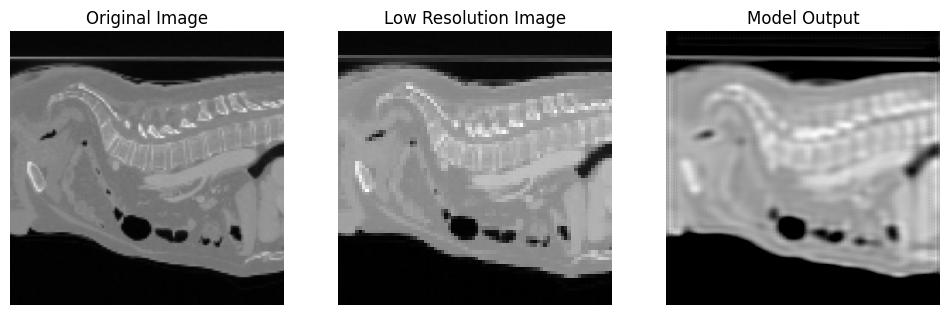

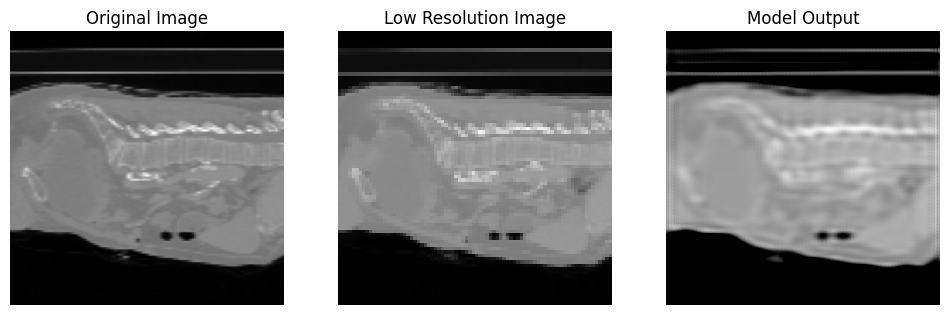

Validation - Epoch [90/200], SSIM: 0.6273, PSNR: 26.9978, MSE: 0.0010


Validation - Epoch [91/200], SSIM: 0.7273, PSNR: 28.3454, MSE: 0.0011


Validation - Epoch [92/200], SSIM: 0.7065, PSNR: 28.2201, MSE: 0.0006


Validation - Epoch [93/200], SSIM: 0.6166, PSNR: 27.1815, MSE: 0.0008


Validation - Epoch [94/200], SSIM: 0.6563, PSNR: 27.5263, MSE: 0.0010


Validation - Epoch [95/200], SSIM: 0.6257, PSNR: 27.5837, MSE: 0.0009


Validation - Epoch [96/200], SSIM: 0.7351, PSNR: 28.8203, MSE: 0.0007


Validation - Epoch [97/200], SSIM: 0.8288, PSNR: 28.5938, MSE: 0.0006


Validation - Epoch [98/200], SSIM: 0.8037, PSNR: 29.8624, MSE: 0.0005


Validation - Epoch [99/200], SSIM: 0.7316, PSNR: 28.1907, MSE: 0.0008


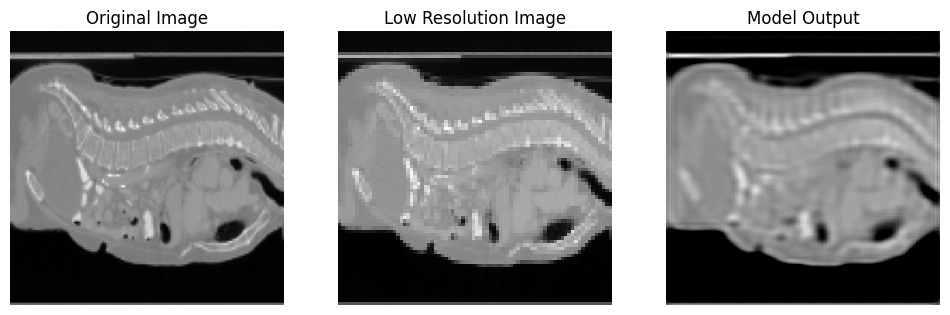

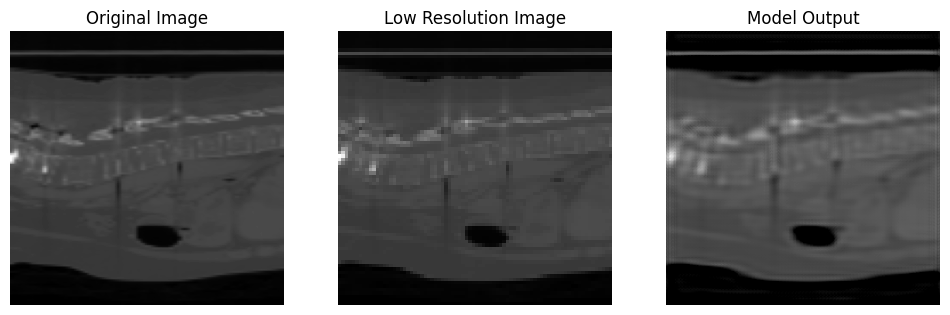

Validation - Epoch [100/200], SSIM: 0.7193, PSNR: 28.5240, MSE: 0.0004


Validation - Epoch [101/200], SSIM: 0.7469, PSNR: 28.7183, MSE: 0.0008


Validation - Epoch [102/200], SSIM: 0.7442, PSNR: 28.6218, MSE: 0.0009


Validation - Epoch [103/200], SSIM: 0.7682, PSNR: 29.1253, MSE: 0.0009


Validation - Epoch [104/200], SSIM: 0.8198, PSNR: 30.3549, MSE: 0.0003


Validation - Epoch [105/200], SSIM: 0.7541, PSNR: 27.6376, MSE: 0.0008


Validation - Epoch [106/200], SSIM: 0.6263, PSNR: 27.2590, MSE: 0.0005


Validation - Epoch [107/200], SSIM: 0.6750, PSNR: 28.2248, MSE: 0.0007


Validation - Epoch [108/200], SSIM: 0.6954, PSNR: 29.0407, MSE: 0.0005


Validation - Epoch [109/200], SSIM: 0.6745, PSNR: 28.2969, MSE: 0.0007


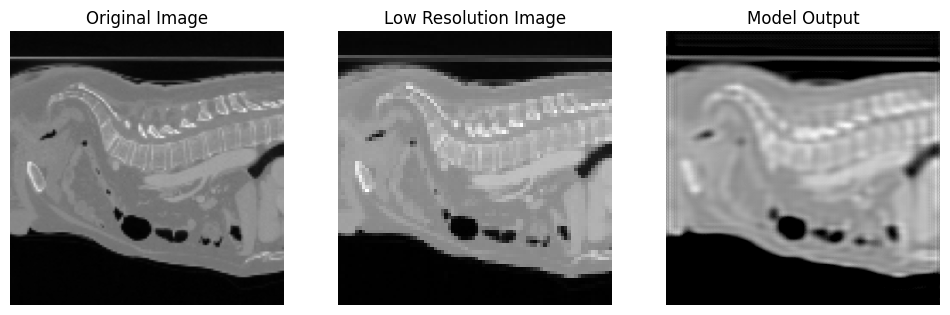

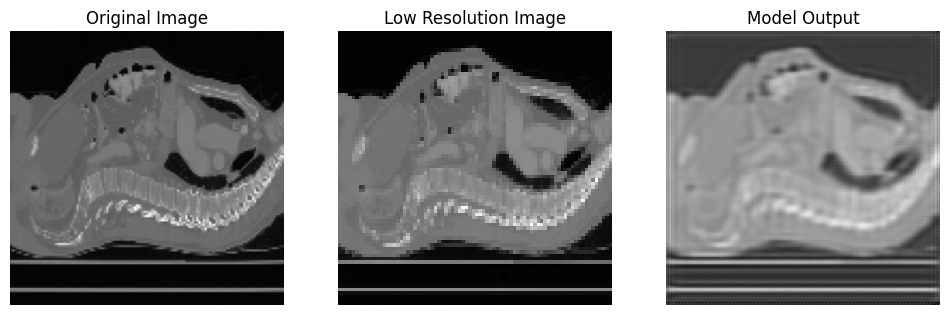

Validation - Epoch [110/200], SSIM: 0.7361, PSNR: 27.7132, MSE: 0.0008


Validation - Epoch [111/200], SSIM: 0.7382, PSNR: 28.5583, MSE: 0.0007


Validation - Epoch [112/200], SSIM: 0.8172, PSNR: 30.1065, MSE: 0.0007


Validation - Epoch [113/200], SSIM: 0.8153, PSNR: 30.1951, MSE: 0.0005


Validation - Epoch [114/200], SSIM: 0.7150, PSNR: 28.5398, MSE: 0.0010


Validation - Epoch [115/200], SSIM: 0.7979, PSNR: 29.3375, MSE: 0.0005


Validation - Epoch [116/200], SSIM: 0.7446, PSNR: 28.7701, MSE: 0.0008


Validation - Epoch [117/200], SSIM: 0.8241, PSNR: 30.9220, MSE: 0.0005


Validation - Epoch [118/200], SSIM: 0.7578, PSNR: 29.4557, MSE: 0.0008


Validation - Epoch [119/200], SSIM: 0.7575, PSNR: 28.3535, MSE: 0.0010


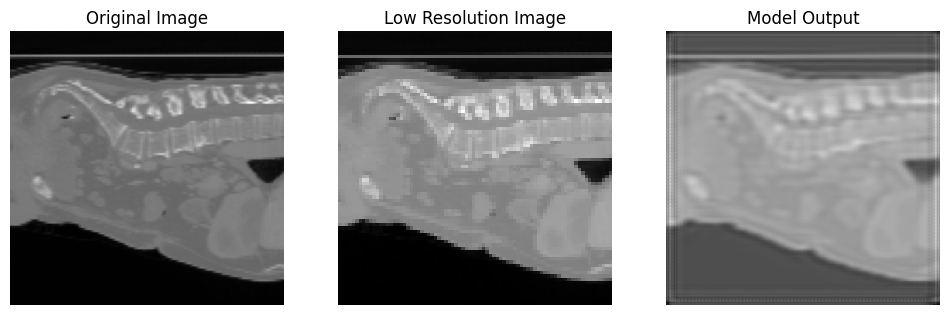

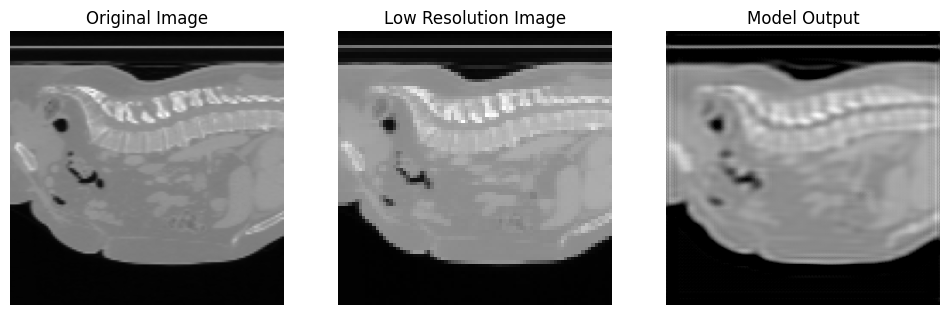

Validation - Epoch [120/200], SSIM: 0.8019, PSNR: 29.2524, MSE: 0.0007


Validation - Epoch [121/200], SSIM: 0.7912, PSNR: 29.5128, MSE: 0.0007


Validation - Epoch [122/200], SSIM: 0.7704, PSNR: 29.1556, MSE: 0.0007


Validation - Epoch [123/200], SSIM: 0.7316, PSNR: 28.0322, MSE: 0.0006


Validation - Epoch [124/200], SSIM: 0.7409, PSNR: 28.1083, MSE: 0.0006


Validation - Epoch [125/200], SSIM: 0.8622, PSNR: 24.5308, MSE: 0.0021


Validation - Epoch [126/200], SSIM: 0.6249, PSNR: 27.7020, MSE: 0.0006


Validation - Epoch [127/200], SSIM: 0.7989, PSNR: 30.3345, MSE: 0.0004


Validation - Epoch [128/200], SSIM: 0.7847, PSNR: 28.8817, MSE: 0.0009


Validation - Epoch [129/200], SSIM: 0.7593, PSNR: 28.9313, MSE: 0.0007


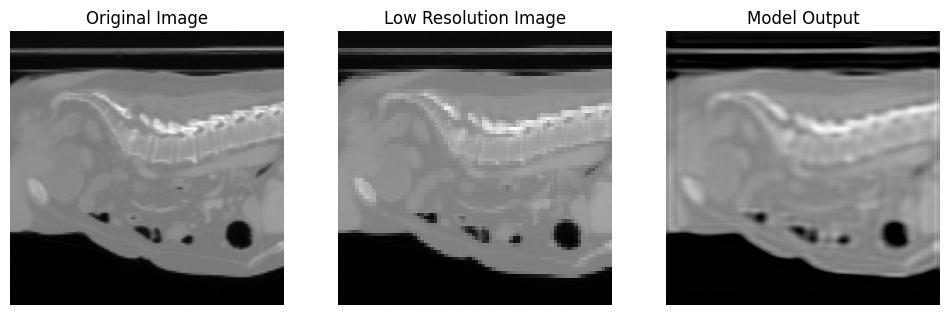

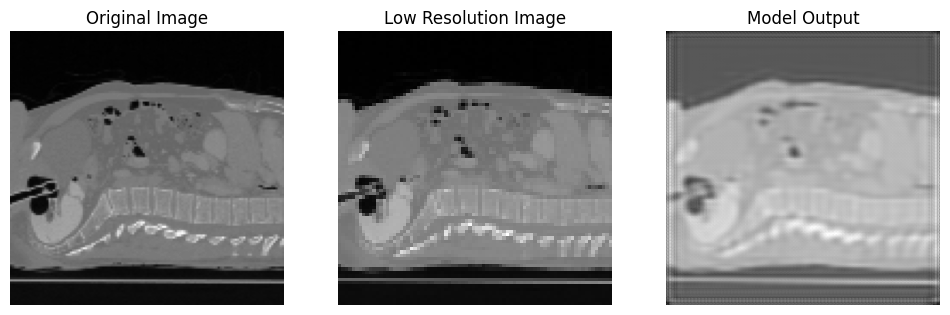

Validation - Epoch [130/200], SSIM: 0.7996, PSNR: 29.6045, MSE: 0.0007


Validation - Epoch [131/200], SSIM: 0.7284, PSNR: 29.2510, MSE: 0.0003


Validation - Epoch [132/200], SSIM: 0.8017, PSNR: 30.6376, MSE: 0.0003


Validation - Epoch [133/200], SSIM: 0.7241, PSNR: 27.8966, MSE: 0.0009


Validation - Epoch [134/200], SSIM: 0.7687, PSNR: 29.8270, MSE: 0.0004


Validation - Epoch [135/200], SSIM: 0.8475, PSNR: 29.9150, MSE: 0.0005


Validation - Epoch [136/200], SSIM: 0.7791, PSNR: 30.1467, MSE: 0.0006


Validation - Epoch [137/200], SSIM: 0.8782, PSNR: 31.2610, MSE: 0.0005


Validation - Epoch [138/200], SSIM: 0.7719, PSNR: 29.0343, MSE: 0.0007


Validation - Epoch [139/200], SSIM: 0.7161, PSNR: 29.3375, MSE: 0.0002


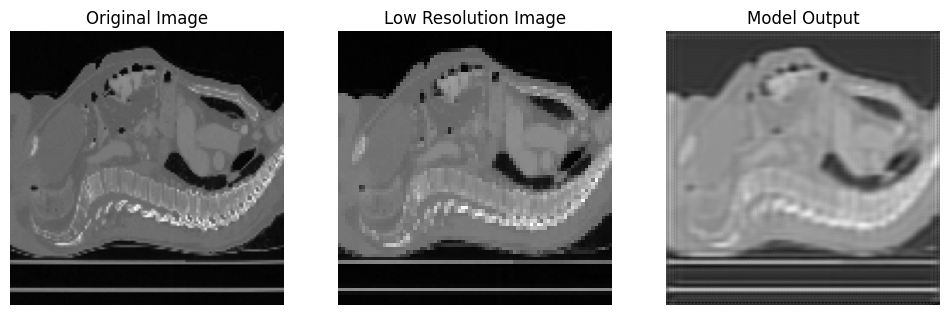

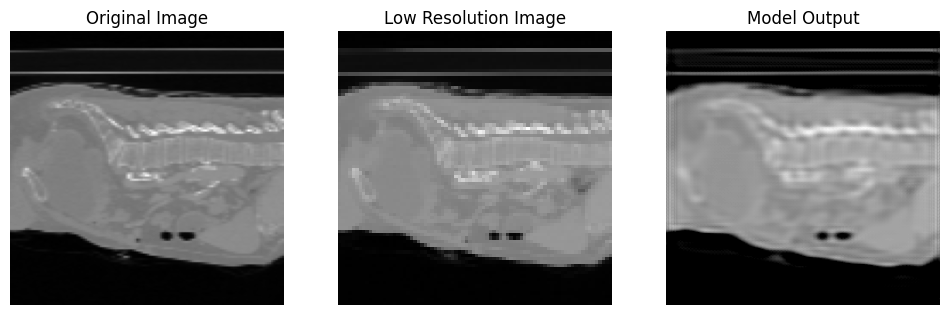

Validation - Epoch [140/200], SSIM: 0.7324, PSNR: 28.1123, MSE: 0.0004


Validation - Epoch [141/200], SSIM: 0.7869, PSNR: 29.9075, MSE: 0.0004


Validation - Epoch [142/200], SSIM: 0.7315, PSNR: 28.2733, MSE: 0.0004


Validation - Epoch [143/200], SSIM: 0.8032, PSNR: 29.6749, MSE: 0.0004


Validation - Epoch [144/200], SSIM: 0.8373, PSNR: 31.0442, MSE: 0.0004


KeyboardInterrupt: 

In [29]:
writer = SummaryWriter('runs/FSRCNN3D_3')

num_epochs = 200

for epoch in range(num_epochs):
    model.train()

    start_time = time.time()  

    for i, (low_res_inputs, high_res_targets) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        low_res_inputs = low_res_inputs.to(device)
        high_res_targets = high_res_targets.to(device)
        outputs = model(low_res_inputs)
        outputs_resized = F.interpolate(outputs, size=high_res_targets.shape[2:], mode='trilinear', align_corners=False)
        loss = criterion(outputs_resized, high_res_targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        writer.add_scalar('Loss/train', loss.item(), epoch * len(train_loader) + i)

    epoch_time = time.time() - start_time

    if torch.cuda.is_available():
        gpu_memory_allocated = torch.cuda.memory_allocated(device) / (1024 ** 2) 
        gpu_memory_reserved = torch.cuda.memory_reserved(device) / (1024 ** 2)    
        writer.add_scalar('GPU/Memory Allocated (MB)', gpu_memory_allocated, epoch)
        writer.add_scalar('GPU/Memory Reserved (MB)', gpu_memory_reserved, epoch)

    writer.add_scalar('Performance/Epoch Time (s)', epoch_time, epoch)

    model.eval()
    ssim_total, psnr_total, mse_total = 0, 0, 0
    selected_images = random.sample(range(len(val_loader.dataset)), k=2)

    with torch.no_grad():
        for idx in selected_images:
            low_res_input, high_res_target = val_loader.dataset[idx]
            low_res_input = low_res_input.unsqueeze(0).to(device)
            high_res_target = high_res_target.unsqueeze(0).to(device)
            outputs = model(low_res_input)
            outputs_resized = F.interpolate(outputs, size=high_res_target.shape[2:], mode='trilinear', align_corners=False)
            ssim_val, psnr_val, mse_val = calculate_metrics(outputs_resized, high_res_target)
            ssim_total += ssim_val
            psnr_total += psnr_val
            mse_total += mse_val

            if (epoch + 1) % 10 == 0:
                torch.save(model.state_dict(), f'model3/FSRCNN3D_epoch_{epoch+1}.pth')
                visualize_images(high_res_target[0], low_res_input[0], outputs[0])



    avg_ssim = ssim_total / len(selected_images)
    avg_psnr = psnr_total / len(selected_images)
    avg_mse = mse_total / len(selected_images)
    writer.add_scalar('SSIM/val', avg_ssim, epoch)
    writer.add_scalar('PSNR/val', avg_psnr, epoch)
    writer.add_scalar('MSE/val', avg_mse, epoch)

    print(f'Validation - Epoch [{epoch + 1}/{num_epochs}], SSIM: {avg_ssim:.4f}, '
          f'PSNR: {avg_psnr:.4f}, MSE: {avg_mse:.4f}')

/tmp/ipykernel_589170/3942340376.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/FSRCNN3D_epoch_100.pth'))


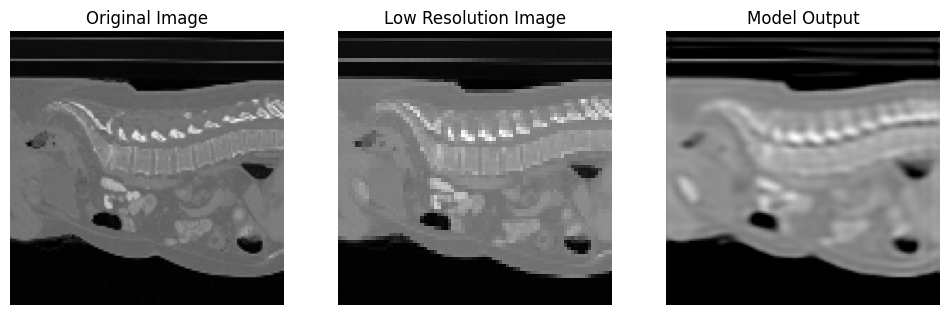

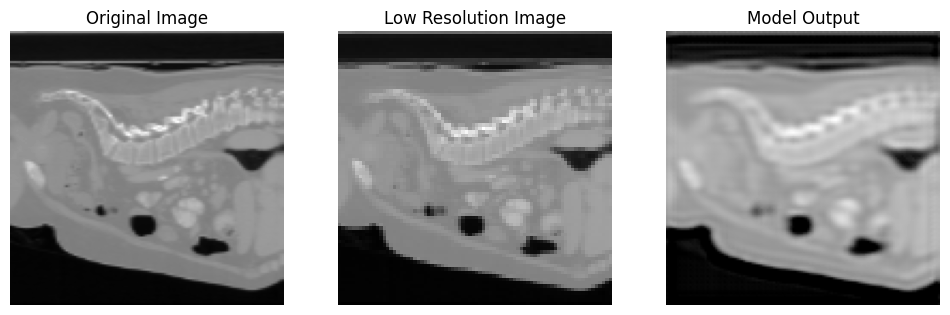

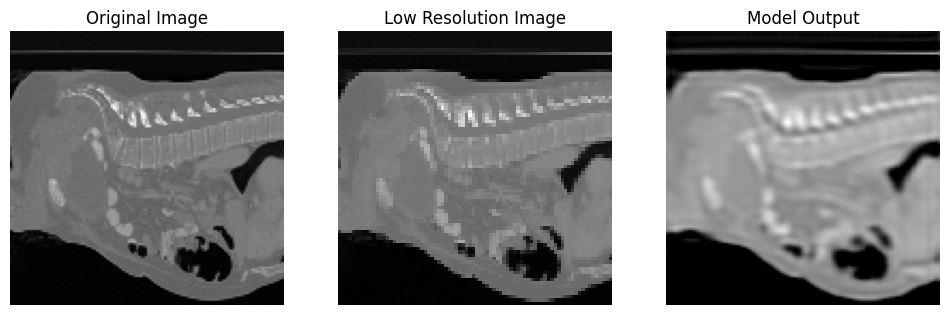

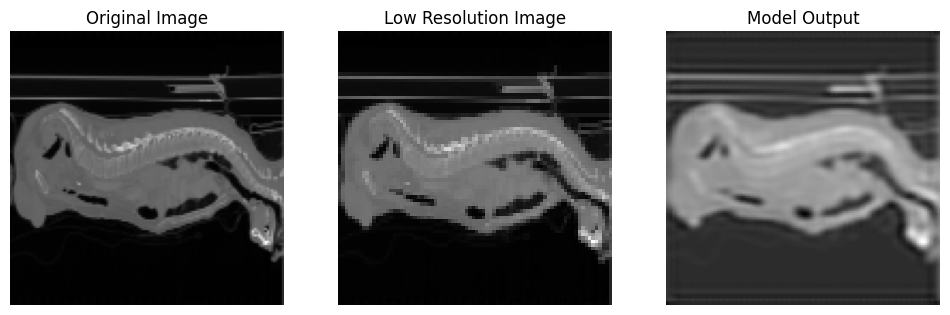

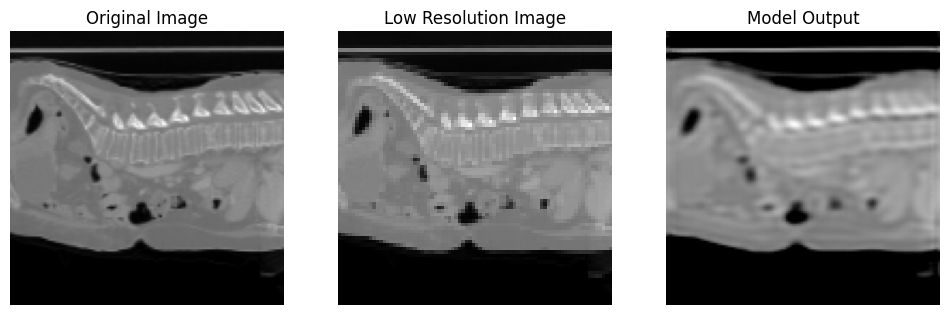

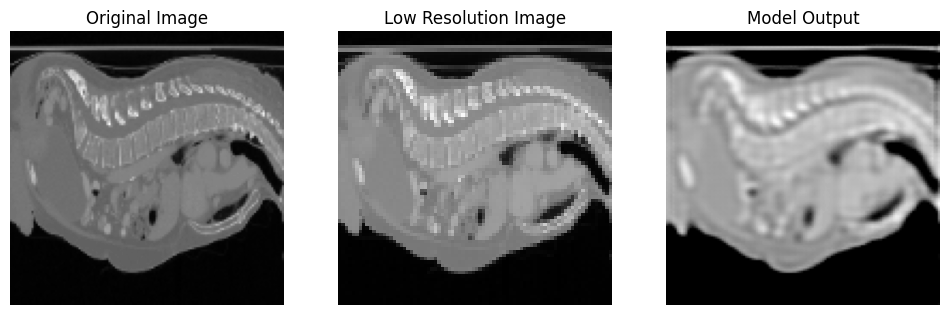

Test Results - SSIM: 0.7859, PSNR: 30.4295, MSE: 0.0007


In [ ]:
def test_model():
    model.load_state_dict(torch.load('models/FSRCNN3D_epoch_100.pth'))  
    model.eval()
    ssim_total, psnr_total, mse_total = 0, 0, 0  
    num_test_images = min(20, len(test_loader)) 

    with torch.no_grad():
        for i, (low_res_inputs, high_res_targets) in enumerate(test_loader):
            if i >= 20: 
                break
            low_res_inputs = low_res_inputs.to(device)
            high_res_targets = high_res_targets.to(device)
            outputs = model(low_res_inputs)
            outputs_resized = F.interpolate(outputs, size=high_res_targets.shape[2:], mode='trilinear', align_corners=False)

            ssim_val, psnr_val, mse_val = calculate_metrics(outputs_resized, high_res_targets)
            ssim_total += ssim_val
            psnr_total += psnr_val
            mse_total += mse_val

            if i < 20:  
                visualize_images(high_res_targets[0], low_res_inputs[0], outputs_resized[0])


    avg_ssim = ssim_total / num_test_images
    avg_psnr = psnr_total / num_test_images
    avg_mse = mse_total / num_test_images

    print(f'Test Results - SSIM: {avg_ssim:.4f}, PSNR: {avg_psnr:.4f}, MSE: {avg_mse:.4f}')

test_model()